In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
from os import getcwd
import numpy as np
from tqdm import tqdm
import re
from typing import Tuple, Dict, Sequence, List, Union
from copy import deepcopy
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from copy import deepcopy

In [1]:
from modern_slavery_registry.utils import (generate_hash,
                                           sort_dict)

In [4]:
DATA_PATH = getcwd()
DATA_PATH = DATA_PATH.replace("notebooks", "")
DATA_PATH += "data"
SHEETS_PATH = DATA_PATH + "\\sheets"

In [5]:
data = pd.read_excel(f"{SHEETS_PATH}\\combined_modern_slavery_statements.xlsx")
data.fillna("#NA", inplace=True)

In [6]:
data.head(2)

,Company ID,Company,Statement ID,URL,statement(Edgar),statement(Nitin),final_statement,final_statement(E/N),final_statement_cleaned
0,7676,"""K"" Line Holding Europe Limited",35092,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,E,holdinc europe ltd modern slavery act transpar...
1,28660,"""K"" Line Bulk Shipping (UK) Limited",35092,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,E,holdinc europe ltd modern slavery act transpar...


# Further text cleaning

In [7]:
# generating unique for statement to avoid processing multiple time processing of same statement
data["statement_hash"] = [
    generate_hash(statement) for statement in tqdm(data["final_statement_cleaned"])]

100%|█████████████████████████████████████████████████████████████████████████| 28364/28364 [00:00<00:00, 97502.70it/s]


In [8]:
subset_data = data[["statement_hash", 
                    "final_statement_cleaned"]].drop_duplicates("statement_hash")

In [9]:
len(data), len(subset_data)

(28364, 14588)

In [10]:
subset_data.head()

,statement_hash,final_statement_cleaned
0,54a3be2e54d7e83866249741309a4fec,holdinc europe ltd modern slavery act transpar...
1,c20780d56b38fdee0d585b1dcf32b246,holdinc europe ltd modern slavery act transpar...
2,ba93a3f728608e0a8aa60765e7433654,holdinc europe ltd modern slavery act transpar...
3,160f2895b670d4054d3dfd9ae1231b87,holdinc europe ltd modern slavery act transpar...
4,c7892425aa35519093b7a0179d245a0d,k line holdinc europe ltd modern slavery act t...


# Lemmatizing

In [11]:
lemmatizer = WordNetLemmatizer() # wordnet lemmatizer object
cleaned_statements = []
for statement in tqdm(subset_data["final_statement_cleaned"], position=0, leave=True):
    cleaned_statements.append(
        " ".join(
            lemmatizer.lemmatize(word, pos="v") for word in statement.split()))

100%|███████████████████████████████████████████████████████████████████████████| 14588/14588 [01:01<00:00, 238.56it/s]


In [12]:
word_sizes = {}
vocab = {}
for statement in tqdm(cleaned_statements, position=0, leave=True):
    for word in statement.split():
        size = len(word)
        if word not in vocab:
            vocab[word] = 1
        else:
            vocab[word] += 1
        if size not in word_sizes:
            word_sizes[size] = 1
        else:
            word_sizes[size] += 1

100%|██████████████████████████████████████████████████████████████████████████| 14588/14588 [00:08<00:00, 1704.75it/s]


In [13]:
word_sizes = sort_dict(word_sizes, by=0)

In [14]:
print(f"Total vocab size: {len(vocab)}, total distinct word sizes: {len(word_sizes)}")

Total vocab size: 47857, total distinct word sizes: 85


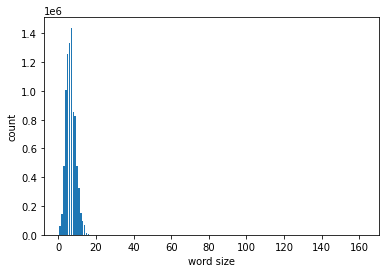

In [15]:
fig, ax = plt.subplots()
ax.bar(word_sizes.keys(), word_sizes.values())
ax.set_xlabel("word size")
ax.set_ylabel("count")
plt.show()

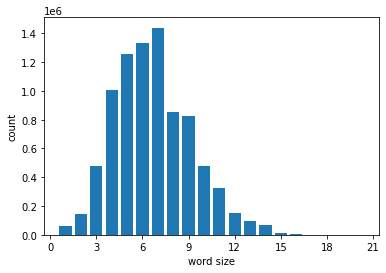

In [16]:
fig, ax = plt.subplots()
ax.bar(list(word_sizes.keys())[:20], list(word_sizes.values())[:20])
ax.set_xlabel("word size")
ax.set_ylabel("count")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

From above plot, it seems like max word size can be restricted to 15 and min word size to 2

In [17]:
MIN_WORD_SIZE = 2
MAX_WORD_SIZE = 15

In [18]:
temp_cleaned_statements = []
for statement in tqdm(cleaned_statements, position=0, leave=True):
    temp_cleaned_statements.append(
        " ".join([word for word in statement.split() 
                  if MIN_WORD_SIZE <= len(word) <= MAX_WORD_SIZE]))
cleaned_statements = deepcopy(temp_cleaned_statements)

100%|██████████████████████████████████████████████████████████████████████████| 14588/14588 [00:02<00:00, 5200.48it/s]


In [19]:
sub_word_sizes = {}
sub_vocab = {}
for statement in tqdm(cleaned_statements, position=0, leave=True):
    for word in statement.split():
        size = len(word)
        if word not in sub_vocab:
            sub_vocab[word] = 1
        else:
            sub_vocab[word] += 1
        if size not in sub_word_sizes:
            sub_word_sizes[size] = 1
        else:
            sub_word_sizes[size] += 1

100%|██████████████████████████████████████████████████████████████████████████| 14588/14588 [00:08<00:00, 1628.83it/s]


In [20]:
sub_word_sizes = sort_dict(sub_word_sizes, by=0)
sub_vocab = sort_dict(sub_vocab, by=1, reverse=True)

In [21]:
print(f"Total vocab size: {len(sub_vocab)}, total distinct word sizes: {len(sub_word_sizes)}")

Total vocab size: 45961, total distinct word sizes: 14


In [22]:
subset_data["cleaned_statements"] = cleaned_statements

In [30]:
subset_data.to_excel(f"{SHEETS_PATH}\\subset_data.xlsx", index=False)